In [1]:
# Run this to allow plotting in the notebook
%pylab inline

# Run this to allow using the %%R cell magic
%load_ext rpy2.ipython

# Suppress warnings (most notable from rpy2)
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Week 4 Lab: You are what you eat (differential expression)

**Due: Monday 4/29/19 11:59pm**
Skills: differential expression, enrichment analysis

## Intro
You would like to study the effects that eating a high fat diet might have on your health. To explore this, you perform an experiment using mice. You feed three mice a standard "chow" diet and another three mice a high fat diet ("HFD"). After 7 weeks, you collect liver biopsies from each of the six mice and perform RNA-sequencing. You'd like to analyze the RNA-seq results to determine which genes changed their expression, and what those genes might be doing.

In this lab, we'll go through:
1. Alignment and visualization of RNA-seq data
2. How to quantify gene expression based on the alignments
3. Differential expression analysis
4. "GO" Enrichment analysis to characterize differentially expressed genes.

### Note on new lab notebook format
This week, we'll be transitioning away from the 2-part assignments we had for the first three weeks. Instead, we'll us a new format with a single assignment. You will see 2 notebooks:
* `CSE185-SPRING19-LAB4-INSTRUCTIONS`: will provide instructions (and hints) about the analyses you'll be performing that week. There are no points associated with this notebook. Instructions marked in <font color="red">red</font> point out specifically what will need to be included in the report notebook. Question labels here (e.g. <font color="red">Methods-Q1</font>, <font color="red">Results-Q1</font> etc. should match up with question labels in the report notebook.
* `CSE185-SPRING19-LAB4-REPORT`: This will be structured in a lab report format, with prompts for what needs to be included and how many points each section is worth.

In general, we will not be asking you to paste specific commands you used to get your answer. However, it is a good practice to keep a document where you keep track of exactly the commands you used for each analysis, so that you can come back to it next week (or next year!) and remember what you did. In lecture we'll go over some tips for doing this.

The goal of this new format is two-fold: (1) to give you more flexibility and independence in running the different tools (We will still provide plenty of examples in the instruction notebook), and (2) to get ready for the format you'll be using for final projects (and also for doing analyses and writing publications in the real world! This week's lab should have fewer actual things to code than previous labs.

### Summary of tools covered
In this lab we'll be using (or at least referring to) the following tools:

* [STAR](https://github.com/alexdobin/STAR) for aligning RNA-seq reads to a reference transcriptome.
* [IGV](https://software.broadinstitute.org/software/igv/) a genome browser. Used for visualizing RNA-seq alignments (and other types of genomic data)
* [RSEM](https://deweylab.github.io/RSEM/) for quantifying gene expression. RSEM takes aligned reads as input and outputs expression levels for each gene.
* [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) for differential expression analysis. This is an R package. It takes in gene expression levels across multiple replicates of multiple conditions and determines which genes are differentially expressed.
* [goatools](https://github.com/tanghaibao/goatools) for performing gene ontology enrichment analyses. This is a Python package but also offers a standalone tool for running GO analysis.

Note: Because DESeq2 is only available as an R package, we'll be writing a small bit of R code which will mostly be provided for you here in the instructions.

And as usual, we'll do some plotting with the [matplotlib](https://matplotlib.org/) Python library (or, whatever method you want to use for plotting. You do not have to use matplotlib. If you are an R person, you can also write R code directly in Jupyter notebooks as we'll see below).

### Summary of data provided
As usual, data for this week can be found in `/datasets/cs185s-sp19-public/week4`. You should see:

* `fastqs/`: This directory contains a fastq file for each of our datasets, `Chow_RepX.fq` and `HFD_RepX.fq` where `X` is 1, 2, or 3.
* `genomeBams/`: This directory contains BAM files based on alignment of reads to a *reference genome* (more on this below).
* `txBams/`: This directory contains BAM files based on alignment of reads to a *reference transcriptome* (more on this below).
* `tdfs/`: This directory contains `tdf` files which we'll use for visualizing alignments using a genome browser (IGV. optional this week but a good idea since we'll be using this again next week.)
* The `RSEM/` and `STAR/` directories contain indices needed by those tools, similar to the indices used by BWA MEM in lab 1.
* `GOAnalysis/`: This directory contains reference files we'll use for our Gene Ontology analysis.
* `GRCm38.75.gene_names` contains a mapping between ENSEMBL gene ids (`ENSMUSG...`) and gene names (e.g. Cdc45, Klf6)

We have also added a mouse reference genome at: `/datasets/cs185s-sp19-public/genomes/GRCm38.fa` (build GRCm38)



# 1. Alignment of RNA-seq data

As for most NGS analyses we'll be doing (besides assembly), the first step is to align our reads so we know where they came from. As we discussed in lab, we cannot simply align reads to the reference genome using something like BWA-MEM, since this does not take into account "splice junctions" that will be prevalent in our RNA-seq data.

<font color="red">**FOR YOUR REPORT (Methods-Q1)**</font> Summarize the dataset we are starting with: how many samples are we analyzing, where did they come from, how many RNA-seq reads were collected for each sample, and what is the read length?

We will be using an RNA-seq aligner called STAR for this. STAR takes in fastq files and a reference *transcriptome* and outputs BAM files with aligned reads. **Because STAR can be very memory intensive (20+GB RAM), we have already run this for you. We will still walk through the steps to run it here as a reference for using this in the future (for example if you end up using RNA-seq data in your final project).**

First, similar to BWA-MEM, we need to create an "index" that will be used during alignment to rapidly look up where each read came from. We created an index using the following command:

```shell
# Don't run this! Shown FYI
REFFA=/datasets/cs185s-sp19-public/genomes/GRCm38.fa
GTF=/datasets/cs185s-sp19-public/genomes/GRCm38.75.gtf
STARDIR=/datasets/cs185s-sp19-public/week4/STAR
STAR \
    --runMode genomeGenerate \
    --genomeDir ${STARDIR} \
    --genomeFastaFiles ${REFFA} \
    --sjdbGTFfile ${GTF} \
    --sjdbOverhang 49
```

<blockquote>UNIX TIP: Note, in the above command we are taking advantage of bash variables. We can define variables using the syntax: VAR=value (important, no spaces!) then reference variables using \$VAR or \${VAR}.</blockquote>

Input parameters to this command were:
* `--runMode genomeGenerate`: tells STAR we're creating an index
* `--genomeDir ${STARDIR}`: tells STAR where to put the output files
* `--genomeFastaFiles ${REFFA}` pointed STAR to the fasta file for our reference genome. Here we are using a mouse genome with the GRCm38 build.
* `--sjdbGTFfile ${GTF}` provides the gene annotations (GTF format). This file is critical for telling STAR where all the exon-exon boundaries are and where genes start and end. You should take a look at this file to get an idea of what these gene annotations look like. See the [GTF format spec](https://uswest.ensembl.org/info/website/upload/gff.html) and lecture slides for more details. This file was created by ENSEMBL build 75 (http://feb2014.archive.ensembl.org/Mus_musculus/Info/Index).
* `--sjdbOverhang` should be set to the read length -1 according to the STAR manual.

After creating the index, we can align reads to the transcriptome. We used the following bash commands to run the alignment:

```shell
# Don't run this! Shown FYI
OUTDIR=/datasets/cs185s-sp19-public/week4/
STARDIR=/datasets/cs185s-sp19-public/week4/STAR

# STAR options recommended by ENCODE
STAROPTS="--outSAMattributes NH HI AS NM MD \
	--outFilterType BySJout \
	--outFilterMultimapNmax 20 \
	--outFilterMismatchNmax 999 \
	--outFilterMismatchNoverReadLmax 0.04 \
	--alignIntronMin 20 \
	--alignIntronMax 1000000 \
	--alignMatesGapMax 1000000 \
	--alignSJoverhangMin 8 \
	--alignSJDBoverhangMin 1 \
	--sjdbScore 1 \
	--limitBAMsortRAM 50000000000"

for f in Chow_Rep1 Chow_Rep2 Chow_Rep3 HFD_Rep1 HFD_Rep2 HFD_Rep3
do
    STAR \
	--runThreadN 5 \
	--genomeDir ${STARDIR} \
	--readFilesIn ${OUTDIR}/fastqs/${f}.fq \
	--outFileNamePrefix ${OUTDIR}/${f} \
	--outSAMtype BAM SortedByCoordinate \
	--quantMode TranscriptomeSAM ${STAROPTS}
    # Reorganize the output files
    mv ${OUTDIR}/${f}Aligned.toTranscriptome.out.bam ${OUTDIR}/txBams/
    mv ${OUTDIR}/${f}Aligned.sortedByCoord.out.bam ${OUTDIR}/genomeBams/
    samtools index ${OUTDIR}/genomeBams/${f}Aligned.sortedByCoord.out.bam
done
```

<blockquote>UNIX tip: The for loop goes through each of our samples and runs a separate command for each, similar to for loops in Python. You may find the for loop syntax useful for running additional commands below. See more about bash for loops: https://www.cyberciti.biz/faq/bash-for-loop/.</blockquote>

This command uses STAR to align each of our fastq files to the reference genome and reference transcriptome. 

This outputs two BAM files:
* `${f}Aligned.sortedByCoord.out.bam`: contains our reads aligned to the reference mouse *genome* (GRChm38).
* `${f}Aligned.toTranscriptome.out.bam`: contains our reads aligned to the mouse *transcriptome* (Ensembl version 75).

If you do `samtools view` on these files, you will see the first BAM files (genome) are aligned to chromosomes like we are used to (e.g. 1, 2, etc.). The second BAM files (transcriptome) are aligned to *transcripts* (named things like "ENSMUST00000074245"). These transcriptome BAMs are required for the tools in the next section for quantifying gene expression.

A major difference between the two alignments is that alignments of RNA-seq reads to the reference genome will contain large gaps due to splice junctions. Find reads with such gaps by looking for CIGAR scores containing an "N" character (gap). e.g.:
```
samtools view /datasets/cs185s-sp19-public/week4/genomeBams/Chow_Rep1Aligned.sortedByCoord.out.bam | awk '($6 ~ /N/)' | head
```
You should see reads with CIGAR scores like `38M723N12M`. This means a read matched fro 38bp on one exon, spanned a 723bp intron, and matched to 12bp on the next exon. You won't typically see this type of read in the transcriptome BAMs, since in those cases reads were aligned directly to transcripts with intron sequences removed.

It is a good idea (although there no points associated with it here) to visualize your sequencing alignments using a genome browser like IGV to make sure everything went well with the alignment. See the optional IGV section at the end of the lab instructions below.

# 2. Quantifying gene expression

Next, we will use RSEM, a tool for quantifying gene expression from RNA-seq. It takes in reads aligned to the transcriptome, which we obtained using STAR, and outputs estimated expression levels of each gene.

RSEM requires an initial step to preprocess the reference transcriptome, similar to the index step required for sequence alignment. We have run this for you using the command below:

```shell
# Don't run! Shown FYI
REFFA=/datasets/cs185s-sp19-public/genomes/GRCm38.fa
GTF=/datasets/cs185s-sp19-public/genomes/GRCm38.75.gtf
RSEMOUT=/datasets/cs185s-sp19-public/week4/RSEM/RSEM
rsem-prepare-reference \
    --gtf ${GTF} ${REFFA} ${RSEMOUT}
```

This will generate multiple index files with prefix `/datasets/cs185s-sp19-public/week4/RSEM/RSEM*`.

Now, we are ready to run RSEM for expression quantification. The following command shows how to run RSEM on a single sample:

```shell
RSEMOUT=/datasets/cs185s-sp19-public/week4/RSEM/RSEM
rsem-calculate-expression \
	-p 5 \
	--fragment-length-mean -1 \
	--seed-length 25 \
	--bam /datasets/cs185s-sp19-public/week4/txBams/Chow_Rep1Aligned.toTranscriptome.out.bam \
	${RSEMOUT} \
	~/week4/Chow_Rep1
```
(we also included `-p 5` to run on 5 processors to speed this up.)

We need to run `rsem-calculate-expression` on each of the six samples (separately). 

We encourage you to try running this yourself. However, this can take a while (>20 minutes per sample). **So we strongly suggest you first use the precomputed results in the `week4/precomputed` directory which you can copy to `~/week4` so you can move on to complete the rest of the lab.** Then go back and see if you can write a for loop to compute the results yourself using `rsem`.

A successful `rsem` run will create the following output files (for each condition. shown here for `Chow_Rep1`):
* `Chow_Rep1.genes.results`: gene-level expression results
* `Chow_Rep1.isoforms.results`: isoform (transcript)-level expression results

For this week's lab, we will focus on the gene-level results (which combines expression from each isoform of each gene into one value). Take a look at the output file. You will see (among other things): gene_id (a funny looking string like ENSMUSG...), a list of transcript ids for that gene, the length of the gene, and the estimated expression level given in both TPM and FPKM. Refer to the prelab and the lecture slides for more info about the difference between these metrics.

<font color="red">**FOR YOUR REPORT (Methods-Q2)**</font> Describe how reads were aligned and how you quantified expression: what tools were used (even if we ran them for you), which transcriptome did you use for a reference, what non-default parameters did you add? Ideally, you should also include the version of any tools you ran. Most tools will have options like `--version` or `-v` that can print out the version of the tool you have installed.

<font color="red">**FOR YOUR REPORT (Results-Q1)**</font> Summarize the expression results by reporting how many genes were expressed (TPM>0) in each sample.

Since we included three replicate samples for each condition, one way we can assess the quality of our results is by comparing replicate samples. We have provided some Python code below to get you started with computing correlations between samples and how to draw a scatter plot to compare. Since our expression values have a large range, we compare log10 TPM values rather than the raw values themselves.

<font color="red">**FOR YOUR REPORT (Results-Q2)**</font> Provide the pairwise correlation between log10 TPM values for each sample. 

<font color="red">**FOR YOUR REPORT (Results-Q3)**</font> Provide scatter plots comparing TPM values in Chow Rep1 vs. Rep2 and HFD Rep1 vs. REP2.

Populating the interactive namespace from numpy and matplotlib
(0.98897512496131468, 0.0)
(0.98431947744104975, 0.0)


,Chow_Rep1,Chow_Rep2,Chow_Rep3
Chow_Rep1,1.000000,0.984319,0.984712
Chow_Rep2,0.984319,1.000000,0.988975
Chow_Rep3,0.984712,0.988975,1.000000


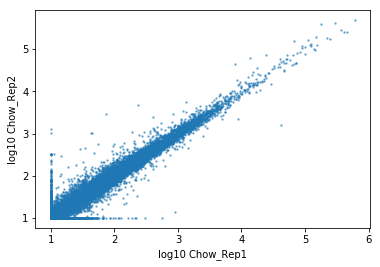

In [2]:
##### Example code for how to compute correlations and draw scatter plots #####

%pylab inline
import os
import pandas as pd
import scipy.stats
OUTDIR="/datasets/cs185s-sp19-public/week4/precomputed/"

# Load data for each sample into a pandas data frame
prefixes = ["Chow_Rep1","Chow_Rep2","Chow_Rep3"]
data = pd.read_csv(os.path.join(OUTDIR, "%s.genes.results"%prefixes[0]), sep="\t")
data = data[["gene_id", "TPM"]]
data.columns = ["gene_id", prefixes[0]]
for i in range(1, len(prefixes)):
    d = pd.read_csv(os.path.join(OUTDIR, "%s.genes.results"%prefixes[i]), sep="\t")
    d = d[["gene_id","TPM"]]
    d.columns = ["gene_id", prefixes[i]]
    data = pd.merge(data, d, on=["gene_id"])
    
# For each sample, take log10 TPM and add a pseudocount of 1 to avoid 0s
for p in prefixes: data[p] = np.log10(data[p]+1)
    
# Correlation scatter plots
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter((data["Chow_Rep1"]+1), (data["Chow_Rep2"]+1), s=2, alpha=0.5)
ax.set_xlabel("log10 Chow_Rep1")
ax.set_ylabel("log10 Chow_Rep2")


# scipy.stats.pearsonr gives correlation (r, pval)
print(scipy.stats.pearsonr((data["Chow_Rep2"]+1), (data["Chow_Rep3"]+1)))
print(scipy.stats.pearsonr((data["Chow_Rep1"]+1), (data["Chow_Rep2"]+1)))

# Pandas can give you pairwise correlation between all pairs of a set of columns
# You can run a similar command in your report to directly print a nicely formatted correlation matrix table!
(data[prefixes].corr())

# 3. Differential expression analysis

Now that we have quantified gene expression in each of our samples, we can perform differential expression analysis. For this, we will be using DESeq2, a widely used method that takes in "counts" (numbers of reads aligned to each gene) for different samples and outputs a set of differentially expressed genes.

This tool is an R package, and so must be run from R. Fortunately, we can write R code directly in Jupyter notebooks using the R "cell magic" (see below). Alternatively, you can open a separate "R" document from JupyterHub or use R at the terminal if that's more comfortable. Since we have not run R before in this course, we have provided the necessary code to run DESeq2 below. The code does the following:

* Loads the `DESeq2` library, as well as the `tximport` library which is needed to load RSEM results
* Sets up the list of files to be used as input to DESeq2. We will input the RSEM results from each of our replicates in each condition.
* Defines which condition each dataset belongs to (the first three are replicates of "Chow", the second three are replicates of "HFD").
* Imports the data to DESeq2 using the `tximport` library
* Runs DESeq2 to find differentially expressed genes.
* Outputs results to `~/week4/chow_vs_hfd_deseq2.csv`.

<font color="red">**FOR YOUR REPORT (Methods-Q3)**</font> Summarize the methods used to detect differentially expressed genes. Even though you didn't have to write this code yourself, you still should summarize what was done following the prompts in the report document.

In [3]:
%%R

##### Load the libraries we need #####
library("DESeq2")
library("tximport")

##### List the files and set up metadata #####
# Note, you should change this to use the files in your home directory
files <- c("/datasets/cs185s-sp19-public/week4/precomputed/Chow_Rep1.genes.results",
         "/datasets/cs185s-sp19-public/week4/precomputed/Chow_Rep2.genes.results",
         "/datasets/cs185s-sp19-public/week4/precomputed/Chow_Rep3.genes.results",
         "/datasets/cs185s-sp19-public/week4/precomputed/HFD_Rep1.genes.results",
         "/datasets/cs185s-sp19-public/week4/precomputed/HFD_Rep2.genes.results",
         "/datasets/cs185s-sp19-public/week4/precomputed/HFD_Rep3.genes.results")
conditions <- c(rep("Chow", 3), rep("HFD", 3))
samples <- data.frame("run"=c("Chow_Rep1", "Chow_Rep2", "Chow_Rep3", "HFD_Rep1", "HFD_Rep2", "HFD_Rep3"),
                    "condition"=conditions)
names(files) = samples$run

##### Use "tximport" to convert RSEM results to the format needed by DESeq2 #####
txi <- tximport(files, type="rsem")
txi$length[txi$length == 0] <- 1 # add pseudocount of 1 to lengths to fix error with 0-length transcripts
ddsTxi <- DESeqDataSetFromTximport(txi, colData=samples, design=~condition)

# Filter things with very low counts to we don't waste time on those
keep <- rowSums(counts(ddsTxi)) >= 10
ddsTxi <- ddsTxi[keep,]

##### Perform deseq2 #####
dds <- DESeq(ddsTxi)
res <- results(dds)

##### Write results to chow_vs_hfd_deseq2.csv #####
write.csv(as.data.frame(res), file="~/week4/chow_vs_hfd_deseq2.csv")

Take a look at the results in the CSV file `~/week4/chow_vs_hfd_deseq2.csv`. The important columns to note are:

* Column 1 (no column header): gives the gene id (e.g. ENSMUSG00000000088)
* Column 3 (log2FoldChange): gives the log2 of the fold change in expression of the gene between conditions
* Column 6 ("pvalue"): gives the p-value for each gene, where here the null hypothesis is that the gene is expressed equally in Chow vs. HFD.
* Column 7 ("padj"): gives the pvalues "adjusted" for the number of hypotheses being tested (false discovery rate).

<font color="red">**FOR YOUR REPORT (Results-Q4)**</font> Following the prompts in the report notebook, visualize the differential expression results using a ["volcano plot"](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)), which plots the log2 fold change vs. the -log10 p-value. Example volcano plots will be shown in Wednesday's lecture slides.

You'll notice all the gene ids are pretty cryptic looking (e.g. ENSMUSG00000000088). We have provided a file, `GRCm38.75.gene_names` in the `week4` directory that can be used to convert these to more canonical gene names. 

<font color="red">**FOR YOUR REPORT (Results-Q5)**</font>. At an adjusted p-value threshold (FDR) of 5%, how many genes were differentially expressed across the two conditions? Report the top 10 most differentially expressed genes, their log2 fold change, and the p-value. Report the gene names (e.g. *Fads2*) rather than gene ids.

# 4. Gene ontology enrichment analysis

Finally, we will use gene ontology (GO) enrichment analysis to characterize the genes that were differentially expressed in Chow vs. HFD.

We outline below a suggested way to do this using script `find_enrichment.py` from the python package `goatools`. However, there are many web tools available for performing GO analysis which you are welcome to use instead (although you're likely to get at least slightly different results with each, they should still give back similar overall categories). For example these tools are pretty popular:

* [DAVID](https://david.ncifcrf.gov/)
* [PANTHER](http://www.pantherdb.org/)
* [GORILLA](http://cbl-gorilla.cs.technion.ac.il/)

For enrichment analysis, we need to define our "foreground" and "background". Here:
* "Background" consists of all genes that we analyzed (i.e., all genes with any output in the DESeq2 csv file).
* "Foreground" consists of all genes that were differentially expressed (padj<0.05). We will create separate foreground sets for up- and down-regulated genes.

Then enrichment analysis will identify which annotations were over- or under-represented in our foreground vs. the background.

The command `find_enrichment.py` can be used for GO analysis. Below is an example command:

```shell
find_enrichment.py sig_genes.txt all_genes.txt mgi.assoc \
    --obo /storage/resources/source/goatools/go-basic.obo \
    --outfile=goea_fdr_bh.xlsx,goea_fdr_bh.tsv --method=fdr_bh --alpha=0.01
```

* `sig_genes.txt` is a file containing a list of gene names of differentially expressed genes.
* `all_genes.txt` is a file containing a list of gene names of all analyzed genes.
* `mgi.assoc` is a file mapping each gene to its annotated GO categories. We have provided this in the `week4/GOAnalysis/` folder
* `go-basic.obo` is a file containing the GO database. It is also provided in the `week4/GOAnalysis/` folder.

<font color="red">**FOR YOUR REPORT (Methods-Q4)**</font> Summarize the methods used to perform enrichment analysis.

<font color="red">**FOR YOUR REPORT (Results-Q6)**</font>. Perform GO enrichment by comparing your differentially expressed genes (adjusted p<0.05) to all genes analyzed. **Perform a separate analaysis for down-regulated (log2 fold change <0) and up-regulated (log2fold change>0) genes**. For each enriched category, provide at least the name of the category and its enrichment p-value.

<font color="red">**FOR YOUR REPORT (Discussion Q1-3)**</font>. Answer the discussion question prompts which will guide us through interpreting the results and considering how our analysis can be improved.

## (Optional) Visualizing alignments in IGV

It is a good practice to visualize our alignments, both to see that the alignment worked well, and also to see whether things we report as differentially expressed make sense. We'll use a genome browser called the [Integrative Genomics Viewer](http://software.broadinstitute.org/software/igv/), or IGV. 

Navigate to the web version of IGV: [https://igv.org/app/](https://igv.org/app/). Set the genome to GRCh38 (mm10). 

Take a moment to orient yourself with IGV. It is basically like a Google Maps for genomes! The top gives the names of each chromosome. The bottom track, labeled "Refseq genes" gives the names and coordinates for all annotated genes. Let's choose one to look at. Type "Fads2" in the search box at the top. This will zoom the view in on this gene. Notice how in the gene you can see the exon and intron structure. The little arrows in the introns point to the left, which means this gene is on the reverse strand of the reference. Take a look at another gene (e.g. Cyp2b10) to see a gene on the forward strand. Zoom in further (using the "+" at the top right) until you can see actual DNA sequence at the top.

Now we'd like to load our sequence alignments. While IGV can directly visualize BAM files, we'll instead look at "counts" files (".tdf" format) which are much smaller. These give read counts per position (i.e. coverage) which can give us an idea of the abundance of each gene. We have preprocessed the BAM files into tdf using a command line tool offered by IGV (`igvtools`, which is not currently installed on datahub). To access these files locally on your desktop or laptop, first copy them to your home directory:

```shell
cp /datasets/cs185s-sp19-public/week4/tdfs/*.tdf .
```

Then from your JupyterHub home page you can click the checkbox next to each one and download the files. In IGV, click "Tracks" then "Local file" and select the tdf files you just downloaded.

Navigate again to Fads2 (This should be one of your differentially expressed genes!). Note that the RNA-seq tracks have very "spiky" coverage. Some regions have tons of reads and others are flat. Note how that compares to the structure of the gene annotated on the bottom. As expected, the "spikes" correspond to reads from exons, since intron and intergenic sequences generally aren't sequenced in our RNA-seq experiment.

Take note of the y-axis range for each dataset (after you initially load them, it should range from 0 to a couple hundred for this gene). To make the tracks more comparable, you can set them all to have the same data range by using the "settings" icon to the left of each track and clicking "set data range". Try setting them all to 500. (the appropriate range will be different for different genes, since genes are really highly expressed whereas others are very lowly expressed. See the huge range on your scatterplot!) 

It is aslo helpful to color tracks. For instance, you can color tracks by condition (see options in settings to the right of each track). An example screenshot is shown below.

<img src=igv_screenshot_lab4.png width=1000>

# References

To read more about the data used for this lab see ["High fat diet-induced changes of mouse hepatic transcription and enhancer activity can be reversed by subsequent weight loss." Siersbaek et al. ](https://www.ncbi.nlm.nih.gov/pubmed/28071704)